# **Connect to Google Drive**



In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


# **Download the zip file**

In [ ]:
import requests

# URL of the zip file to be downloaded
url = 'https://wufs.wustl.edu/SpaceApps/data/space_apps_2024_seismic_detection.zip'

# Path where the file should be saved
output_path = '/content/drive/MyDrive/nasa_space_app/space_apps_2024_seismic_detection.zip'

# Download the file
response = requests.get(url)

# Save the file to the specified path
with open(output_path, 'wb') as file:
    file.write(response.content)

print("Download completed!")


Download completed!


# **Unzip the file**

In [ ]:
# prompt: unzip the file  /content/drive/MyDrive/nasa_space_app/space_apps_2024_seismic_detection.zip

import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/nasa_space_app/space_apps_2024_seismic_detection.zip'

# Directory where the contents should be extracted
extract_dir = '/content/drive/MyDrive/nasa_space_app/extracted_data'

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipping completed!")


Unzipping completed!


We need to make a dataframe to train the cnn model. Dataframe should consist of inputs and outputs. outputs is th  ratio of the division of the image where the sesimic quake occurs. we could convert the relative timestamp to ratio using(time/86400)
. Input is the spectrography image which was made from the periodic collection of data using sesimometer. we need to convert the sesimomter data into a image which shows frequency distribution.

**imports**

In [ ]:
# Import libraries
import re
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset


**write the paths of the all directories where the data is present.**

In [ ]:
# prompt: code to show the contents of the file in the path '/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training'


data_dir = '/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training'

# List all files and directories in the specified path
for item in os.listdir(data_dir):
  item_path = os.path.join(data_dir, item)
  print(item_path)


/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/catalogs
/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/data
/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/plots


In [ ]:


# Define the paths
data_directory = '/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/'
catalog_file = os.path.join(data_directory, 'catalogs', 'apollo12_catalog_GradeA_final.csv')
data_folder = os.path.join(data_directory, 'data', 'S12_GradeA')  # Folder containing .mseed files

# Load the catalog CSV file
catalog_df = pd.read_csv(catalog_file)

# Function to extract timestamps from .mseed files
def extract_timestamps_from_mseed(mseed_file):
    # Read the .mseed file
    st = read(mseed_file)

    # Extract the trace
    tr = st.traces[0].copy()

    # Start time of the trace
    starttime = tr.stats.starttime.datetime

    return starttime

# Create a new DataFrame to store the results
output_data = []

# Get a list of all .mseed files in the data folder
mseed_files = [f for f in os.listdir(data_folder) if f.endswith('.mseed')]

# Iterate over the catalog DataFrame
for index, row in catalog_df.iterrows():
    evid = row['evid']  # Extract evid

    # Use regex to search for a matching .mseed file based on evid
    matching_file = None
    for mseed_file in mseed_files:
        if re.search(f"{evid}", mseed_file):
            matching_file = mseed_file
            break

    # If a matching file is found
    if matching_file:
        # Construct the full path to the .mseed file
        mseed_file_path = os.path.join(data_folder, matching_file)

        # Extract the arrival time from the catalog DataFrame
        arrival_time_str = row['time_abs(%Y-%m-%dT%H:%M:%S.%f)']
        arrival_time = datetime.strptime(arrival_time_str, '%Y-%m-%dT%H:%M:%S.%f')

        # Get start time from the .mseed file
        starttime = extract_timestamps_from_mseed(mseed_file_path)

        # Calculate the relative arrival time
        arrival = (arrival_time - starttime).total_seconds()

        # Append the results to the output_data list
        output_data.append([matching_file, arrival_time_str, arrival, evid])

# Create the output DataFrame
output_df = pd.DataFrame(output_data, columns=['filename', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'evid'])

# Display the first few rows of the output DataFrame
print(output_df.head())


                                       filename  \
0  xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed   
1  xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed   
2  xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed   
3  xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed   
4  xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed   

  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)       evid  
0     1970-01-19T20:25:00.000000      73499.335  evid00002  
1     1970-03-25T03:32:00.000000      12719.560  evid00003  
2     1970-03-26T20:17:00.000000      73019.435  evid00004  
3     1970-04-25T01:14:00.000000       4439.804  evid00006  
4     1970-04-26T14:29:00.000000      52139.340  evid00007  


In [ ]:
# prompt: in the dataframe output_df first row has .mseed extensions file. read the content in the 1st row and 1st column

# Get the filename from the first row and first column
filename = output_df.iloc[0, 0]

# Construct the full path to the .mseed file
mseed_file_path = os.path.join(data_folder, filename)

# Read the content of the .mseed file
try:
  st = read(mseed_file_path)
  print(f"Content of {mseed_file_path}:")
  print(st)
except Exception as e:
  print(f"Error reading {mseed_file_path}: {e}")


Content of /content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed:
1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-01-19T00:00:00.665000Z - 1970-01-20T00:00:02.778208Z | 6.6 Hz, 572415 samples


In [ ]:
import os
import re
from scipy import signal
import matplotlib.pyplot as plt
from obspy import read

# Assuming `output_df` already exists and has 'filename' column
# `output_df` comes from the previous part of the project that includes the mseed filenames.

# Folder to save spectrogram images
output_img_folder = './spectrogram_images/'
os.makedirs(output_img_folder, exist_ok=True)

# Function to create and save a spectrogram
def create_spectrogram(tr, filename, output_folder):
    # Generate the spectrogram
    f, t, Sxx = signal.spectrogram(tr.data, tr.stats.sampling_rate)

    # Create the spectrogram plot
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='jet')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f"Spectrogram for {filename}")

    # Create the file path to save the image
    img_path = os.path.join(output_folder, f"{filename}.png")

    # Save the figure as an image
    plt.savefig(img_path)
    plt.close()

    return img_path

# Folder containing .mseed files (assuming data folder is the same as in the previous code)
data_folder = '/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'

# Iterate over the DataFrame to add spectrogram images
spectrogram_images = []

for index, row in output_df.iterrows():
    evid = row['evid']  # Extract the evid from the DataFrame
    filename = row['filename']  # Extract the filename

    # Use regex to search for a matching .mseed file based on evid
    matching_file = None
    mseed_files = [f for f in os.listdir(data_folder) if f.endswith('.mseed')]  # Get list of .mseed files

    for mseed_file in mseed_files:
        if re.search(f"{evid}", mseed_file):  # Search for the evid in the .mseed filename
            matching_file = mseed_file
            break

    # If a matching file is found, process it
    if matching_file:
        mseed_file_path = os.path.join(data_folder, matching_file)

        # Read the .mseed file
        st = read(mseed_file_path)
        tr = st.traces[0]  # Get the first trace

        # Create the spectrogram and save it as an image
        img_path = create_spectrogram(tr, matching_file, output_img_folder)

        # Append the image path to the list
        spectrogram_images.append(img_path)
    else:
        # If no matching file, append a placeholder (could be None or some indication)
        spectrogram_images.append(None)

# Add the spectrogram images paths to the DataFrame
output_df['spectrogram_image'] = spectrogram_images

# Display the updated DataFrame
print(output_df.head())


                                       filename  \
0  xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed   
1  xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed   
2  xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed   
3  xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed   
4  xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed   

  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)       evid  \
0     1970-01-19T20:25:00.000000      73499.335  evid00002   
1     1970-03-25T03:32:00.000000      12719.560  evid00003   
2     1970-03-26T20:17:00.000000      73019.435  evid00004   
3     1970-04-25T01:14:00.000000       4439.804  evid00006   
4     1970-04-26T14:29:00.000000      52139.340  evid00007   

                                   spectrogram_image  
0  ./spectrogram_images/xa.s12.00.mhz.1970-01-19H...  
1  ./spectrogram_images/xa.s12.00.mhz.1970-03-25H...  
2  ./spectrogram_images/xa.s12.00.mhz.1970-03-26H...  
3  ./spectrogram_images/xa.s12.00.mhz.1970-04-25H...  
4  ./spectrogram_images/xa.s12.00.mhz.1970-04

**Create a model here.**

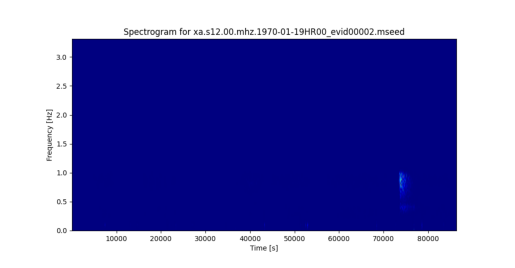

In [ ]:
# prompt: display an image in output_df frame

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if 'spectrogram_image' in output_df.columns:
  # Assuming the first row contains a valid spectrogram image
  first_image_path = output_df['spectrogram_image'].iloc[0]
  if first_image_path:
    try:
      img = mpimg.imread(first_image_path)
      plt.imshow(img)
      plt.axis('off')  # Turn off axis labels
      plt.show()
    except Exception as e:
      print(f"Error displaying image: {e}")
  else:
    print("No spectrogram image found in the DataFrame.")
else:
  print("'spectrogram_image' column not found in the DataFrame.")



In [ ]:
# Divide the 'time_rel(sec)' column by 86400 to convert seconds to days
output_df['time_rel(days)'] = output_df['time_rel(sec)']

# Display the updated DataFrame with the new column
print(output_df.head())


                                       filename  \
0  xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed   
1  xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed   
2  xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed   
3  xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed   
4  xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed   

  time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)       evid  \
0     1970-01-19T20:25:00.000000      73499.335  evid00002   
1     1970-03-25T03:32:00.000000      12719.560  evid00003   
2     1970-03-26T20:17:00.000000      73019.435  evid00004   
3     1970-04-25T01:14:00.000000       4439.804  evid00006   
4     1970-04-26T14:29:00.000000      52139.340  evid00007   

                                   spectrogram_image  time_rel(days)  
0  ./spectrogram_images/xa.s12.00.mhz.1970-01-19H...       73499.335  
1  ./spectrogram_images/xa.s12.00.mhz.1970-03-25H...       12719.560  
2  ./spectrogram_images/xa.s12.00.mhz.1970-03-26H...       73019.435  
3  ./spectrogram_images/xa.s12.00.mh

**Train and test the model. **

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 2363029760.0000 - mae: 41930.2383 - val_loss: 1945665664.0000 - val_mae: 36178.4805
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 926ms/step - loss: 2539659008.0000 - mae: 43944.8594 - val_loss: 1940463360.0000 - val_mae: 36106.5156
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 927ms/step - loss: 2436808704.0000 - mae: 42269.9648 - val_loss: 1926731520.0000 - val_mae: 35915.8594
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 2526050560.0000 - mae: 43652.3867 - val_loss: 1896167168.0000 - val_mae: 35487.8281
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 2542028544.0000 - mae: 44209.0703 - val_loss: 1834936192.0000 - val_mae: 34614.4297
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 2555443456.0000 - mae: 43795.2969 - val_loss: 1725102336.0000 - val_mae: 33060.4023
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 2160720128.0000 - mae: 39493.2812 - val_loss: 1543747712.0000 - val_mae: 30545.5352
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━

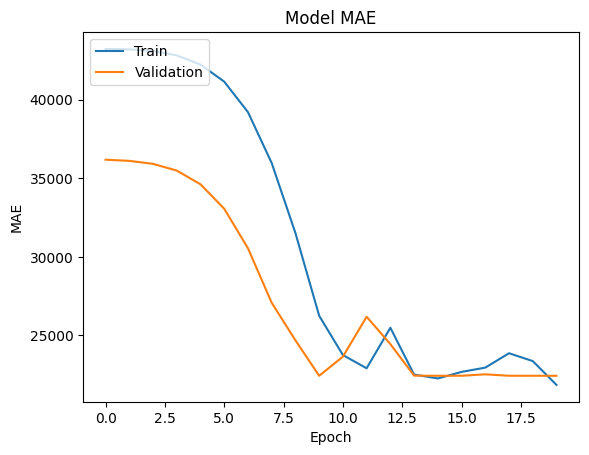

In [ ]:
# prompt: create a optimizes fine tuned CNN model to train on spectogram_image as input and time_Rel(days) as output

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Assuming output_df contains 'spectrogram_image' and 'time_rel(days)' columns
# and that the spectrogram images are loaded into a numpy array 'X' and
# 'time_rel(days)' is loaded into a numpy array 'y'

# Load and preprocess image data
def load_and_preprocess_image(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
  return img_array


X = []
y = []
for index, row in output_df.iterrows():
  if row['spectrogram_image'] is not None:
    try:
      img_array = load_and_preprocess_image(row['spectrogram_image'])
      X.append(img_array)
      y.append(row['time_rel(days)'])
    except Exception as e:
      print(f"Error loading image: {e}")


X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam',
              loss='mse',  # Mean squared error for regression
              metrics=['mae'])  # Mean absolute error

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,  # You can adjust the number of epochs
    validation_data=(X_test, y_test)
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print('Mean Absolute Error:', mae)

# Plot training history
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# prompt: now take a sample from the dataframe and show me the prediction value

# Assuming you have already trained the model and have the 'output_df' DataFrame.

# Select a sample from the DataFrame (e.g., the first row)
sample_row = output_df.iloc[0]

# Get the spectrogram image path from the sample row
sample_image_path = sample_row['spectrogram_image']

if sample_image_path:
  try:
    # Load and preprocess the sample image
    sample_image_array = load_and_preprocess_image(sample_image_path)
    sample_image_array = np.expand_dims(sample_image_array, axis=0)  # Add batch dimension

    # Make a prediction using the trained model
    prediction = model.predict(sample_image_array)

    # Get the predicted value
    predicted_time_rel_days = prediction[0][0]

    print(f"Predicted relative arrival time (in days): {predicted_time_rel_days}")

    # Print the actual relative arrival time (for comparison)
    actual_time_rel_days = sample_row['time_rel(days)']
    print(f"Actual relative arrival time (in days): {actual_time_rel_days}")
  except Exception as e:
    print(f"Error making prediction: {e}")
else:
  print("No spectrogram image found for the sample row.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted relative arrival time (in days): 35716.7421875
Actual relative arrival time (in days): 73499.335


**Save the model**

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 2201021696.0000 - mae: 40208.8984 - val_loss: 3486191616.0000 - val_mae: 55095.3906
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 2190153472.0000 - mae: 39876.5234 - val_loss: 3486145792.0000 - val_mae: 55094.9727
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 2582075136.0000 - mae: 43793.1875 - val_loss: 3485670656.0000 - val_mae: 55090.6602
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 2301746688.0000 - mae: 39650.5469 - val_loss: 3485484800.0000 - val_mae: 55088.9727
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - loss: 1945008512.0000 - mae: 35866.3906 - val_loss: 3485353216.0000 - val_mae: 55087.7812
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 2325120512.0000 - mae: 41040.5469 - val_loss: 3485226752.0000 - val_mae: 55086.6289
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 2206260224.0000 - mae: 40409.4805 - val_loss: 3485114112.0000 - val_mae: 55085.6133
Epoch 

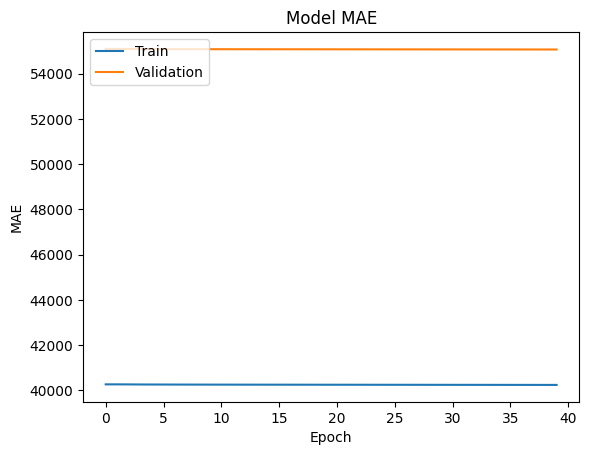

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


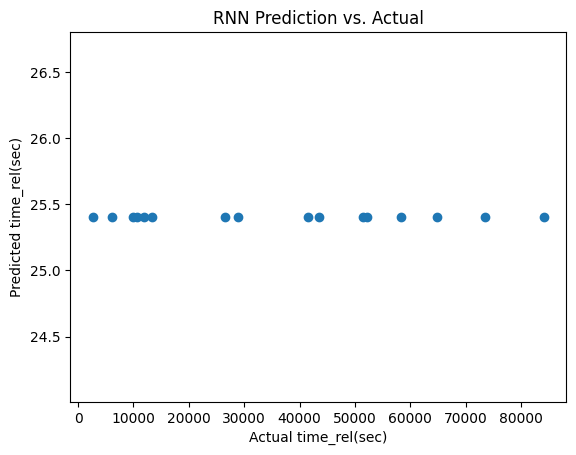

In [ ]:
# prompt: train RNN on .mseed and time_rel(Sec)

from google.colab import drive
import requests
import zipfile
import os
import re
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import cm
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Assuming output_df contains 'filename' and 'time_rel(sec)' columns
# and that the .mseed files are located in 'data_folder'.

# Function to load and preprocess .mseed data
def load_and_preprocess_mseed(mseed_file_path, max_length=1000):
  try:
    st = read(mseed_file_path)
    tr = st[0]  # Assuming only one trace
    data = tr.data[:max_length]  # Truncate to a fixed length
    # Normalize data if needed
    # ...
    return data
  except Exception as e:
    print(f"Error loading {mseed_file_path}: {e}")
    return None


X = []
y = []

data_folder = '/content/drive/MyDrive/nasa_space_app/extracted_data/space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'
for index, row in output_df.iterrows():
  filename = row['filename']
  mseed_file_path = os.path.join(data_folder, filename)
  data = load_and_preprocess_mseed(mseed_file_path)
  if data is not None:
    X.append(data)
    y.append(row['time_rel(sec)'])

X = np.array(X)
y = np.array(y)

# Reshape X for RNN input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RNN model
model = models.Sequential()
model.add(layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print('Mean Absolute Error:', mae)

# Plot training history
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions on the test set
predictions = model.predict(X_test)

# Compare predictions with actual values
plt.scatter(y_test, predictions)
plt.xlabel('Actual time_rel(sec)')
plt.ylabel('Predicted time_rel(sec)')
plt.title('RNN Prediction vs. Actual')
plt.show()

